## Step 1: Initial Setup and Data Loading

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Define file paths for the data
orders_path = '../data/processed_orders.csv'
inventory_path = '../data/inventory.csv'
advertising_path = '../data/advertising.csv'
products_path = '../data/products.csv'
collections_path = '../data/collections.csv'
categories_path = '../data/categories.csv'
supplying_path = '../data/supplying.csv'

# Load the data into DataFrames
orders_df = pd.read_csv(orders_path)
inventory_df = pd.read_csv(inventory_path)
advertising_df = pd.read_csv(advertising_path)
products_df = pd.read_csv(products_path)
collections_df = pd.read_csv(collections_path)
categories_df = pd.read_csv(categories_path)
supplying_df = pd.read_csv(supplying_path)

collection = "Asymmetric mirrors"

# SALES

## Step 2: Sales Analysis Function

In [17]:
def analyze_sales_data(file_path, collection_name):
    """
    Analyzes sales data for a specified collection.

    Parameters:
    file_path (str): The file path to the sales data CSV.
    collection_name (str): The name of the collection to analyze.

    Returns:
    DataFrame: A DataFrame containing the monthly sales analysis for the collection.
    """

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert purchase_date to datetime and extract the month
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['month'] = df['purchase_date'].dt.strftime('%Y-%m')

    # Filter data based on collection name
    filtered_df = df[df['collection'] == collection_name]

    # Group by month and calculate metrics
    grouped = filtered_df.groupby('month').agg(
        Quantity_sold=('quantity', 'sum'),
        Revenue_eur=('item_price', 'sum')
    )

    # Calculate ticket price
    grouped['Ticketprice_eur'] = grouped['Revenue_eur'] / grouped['Quantity_sold']

    # Reset index to make 'month' a column
    grouped = grouped.reset_index()

    return grouped

## Step 3: Display Function for Sales Data

In [18]:
def display_sales_results(grouped_data):
    """
    Displays the sales analysis results in a table and a plot.

    Parameters:
    grouped_data (DataFrame): The DataFrame containing the sales analysis.
    """

    # Display the table
    print(grouped_data)

    # Plotting the graph
    plt.figure(figsize=(6, 3))
    plt.plot(grouped_data['month'], grouped_data['Revenue_eur'], marker='o')
    plt.title('Monthly Sales Revenue')
    plt.xlabel('Month')
    plt.ylabel('Sales Revenue (EUR)')
    plt.grid(True)
    plt.show()

## Step 4: Sales Analysis

     month  Quantity_sold  Revenue_eur  Ticketprice_eur
0  2023-01            578      63594.2       110.024567
1  2023-02            543      60618.2       111.635727
2  2023-03            628      70905.4       112.906688
3  2023-04            532      59443.4       111.735714
4  2023-05            490      55258.9       112.773265
5  2023-06            368      41441.6       112.613043
6  2023-07            240      26793.3       111.638750
7  2023-08            278      31478.1       113.230576
8  2023-09            303      34055.6       112.394719
9  2023-10            365      41388.9       113.394247


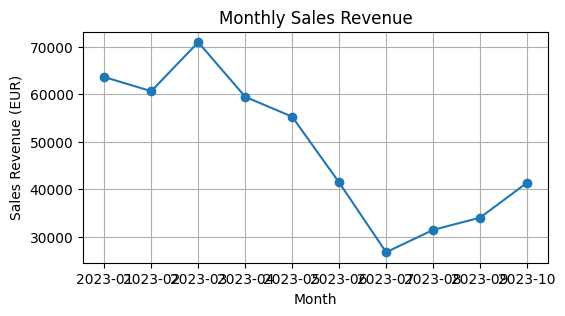

In [19]:
# Example usage
grouped_sales_data = analyze_sales_data(orders_path, collection)
display_sales_results(grouped_sales_data)

# INVENTORY

## Step 5: Function for Current Inventory Level

In [25]:
def analyze_current_inventory(file_path_inventory, file_path_collections, collection_name):
    """
    Analyzes current inventory level for a specified collection.

    Parameters:
    file_path_inventory (str): The file path to the inventory data CSV.
    file_path_collections (str): The file path to the collections data CSV.
    collection_name (str): The name of the collection to analyze.

    Returns:
    int: The current inventory level for the specified collection.
    """

    # Read the inventory and collections data
    inventory_df = pd.read_csv(file_path_inventory)
    collections_df = pd.read_csv(file_path_collections)

    # Convert 'month' to datetime
    inventory_df['month'] = pd.to_datetime(inventory_df['month'], format='%d.%m.%Y')

    # Filter for the latest date
    latest_date = inventory_df['month'].max()
    latest_inventory_df = inventory_df[inventory_df['month'] == latest_date]

    # Join with collections data to get collection names
    final_inventory_df = pd.merge(latest_inventory_df, collections_df, on='collection_id', how='left')

    # Filter for the specified collection and sum the inventory
    collection_inventory = final_inventory_df[final_inventory_df['collection'] == collection_name]
    total_inventory = collection_inventory['inventory'].sum()

    return int(total_inventory)  # Convert to integer

## Step 6: Function for Inventory - Sales Velocity Calculation

In [29]:
def calculate_inventory_metrics(orders_file_path, inventory_file_path, collections_file_path, collection_name):
    """
    Calculates various inventory metrics for a specified collection.

    Parameters:
    orders_file_path (str): The file path to the orders data CSV.
    inventory_file_path (str): The file path to the inventory data CSV.
    collections_file_path (str): The file path to the collections data CSV.
    collection_name (str): The name of the collection to analyze.

    Returns:
    dict: A dictionary containing current inventory level, projected sales, daily sales expectation, and remaining days.
    """

    # Projected sales for the next month
    # projected_sales_next_month = analyze_sales_velocity(orders_file_path, collection_name)

    # Current inventory level
    current_inventory = analyze_current_inventory(inventory_file_path, collections_file_path, collection_name)

    # Daily sales expectation
    # daily_sales_expectation = projected_sales_next_month / 30
    daily_sales_expectation = round(daily_sales_expectation, 1)  # Round to 1 decimal place

    # Remaining days of inventory
    remaining_days = current_inventory / daily_sales_expectation if daily_sales_expectation else 0
    remaining_days = round(remaining_days, 1)  # Round to 1 decimal place

    return {
        "Current inventory level": current_inventory,
        # "Projected sales - next month": int(projected_sales_next_month),  # Rounded to integer
        "Projected sales - daily": daily_sales_expectation,
        "Remaining days of inventory": remaining_days
    }

## Step 7: Function For Replenish Analysis

In [30]:
# Constants
LOGISTICS_DAYS = 15  # Days for logistics
IDEAL_ORDER_AMOUNT = 2  # Months of inventory to order

def calculate_replenishment_details(collection_name, projected_monthly_sales, remaining_days, supplying_df):
    """
    Calculates when and how much to order for replenishing inventory, and the total replenishment time.

    Parameters:
    collection_name (str): The name of the collection.
    projected_monthly_sales (int): Projected sales for the next month.
    remaining_days (float): Remaining days before inventory runs out.
    supplying_df (DataFrame): DataFrame containing supply days for collections.

    Returns:
    dict: A dictionary containing the replenishment date, order quantity, and total replenishment time.
    """

    # Find supply days for the collection
    supply_days = supplying_df[supplying_df['collection'] == collection_name]['supply_days'].iloc[0]

    # Total time to replenish (supply days + logistics days)
    total_replenishment_time = supply_days + LOGISTICS_DAYS

    # Calculate the day to place an order (5 days before projected end)
    order_placement_day = remaining_days - total_replenishment_time - 4 # 4 days before end
    order_placement_day_formatted = f"After {max(order_placement_day, 0):.1f} days"  # Formatted string

    # Calculate the order quantity (2 months of sales)
    order_quantity = projected_monthly_sales * IDEAL_ORDER_AMOUNT

    return {
        "Total Replenishment Time (days)": total_replenishment_time,
        "Order Placement Day": order_placement_day_formatted,
        "Quantity to Order": int(order_quantity),  # Convert to integer
    }

## Step 8: Inventory Analysis

In [31]:
# Example usage
inventory_metrics = calculate_inventory_metrics(orders_path, inventory_path, collections_path, collection)
replenishment_details = calculate_replenishment_details(collection, inventory_metrics["Projected sales - next month"], inventory_metrics["Remaining days of inventory"], supplying_df)

# Display the results
print("Inventory Level Details:")
for key, value in inventory_metrics.items():
    print(f"{key}: {value}")
print("\nReplenishment Details:")
for key, value in replenishment_details.items():
    print(f"{key}: {value}")

UnboundLocalError: local variable 'daily_sales_expectation' referenced before assignment

# ADVERTISING

## Step 9: Function to Display Campaign Details

In [55]:
def display_campaign_details(advertising_df, collection_id):
    """
    Displays details of campaigns for a specified collection.

    Parameters:
    advertising_df (DataFrame): DataFrame containing advertising data.
    collection_id (int): The collection ID to filter campaigns.

    Returns:
    None: Prints the campaign details.
    """

    # Filter campaigns based on collection_id
    campaigns = advertising_df[advertising_df['collection_id'] == collection_id]

    # Select relevant columns
    campaign_details = campaigns[['campaign_name', 'satatus', 'targeting', 'budget']]

    print("Lists of campaigns:")
    print(campaign_details.to_string(index=False))

## Step 10: Function to Show Previous Performance Metrics

In [56]:
def display_previous_performance(advertising_df, collection_id):
    """
    Displays previous performance metrics for campaigns of a specified collection.

    Parameters:
    advertising_df (DataFrame): DataFrame containing advertising data.
    collection_id (int): The collection ID to filter campaigns.

    Returns:
    None: Prints the performance metrics.
    """

    # Filter campaigns based on collection_id
    campaigns = advertising_df[advertising_df['collection_id'] == collection_id]

    # Select relevant performance metrics
    performance_metrics = campaigns[['campaign_name', 'budget', 'spend', 'impressions', 'clicks', 'CTR', 'orders', 'sales', 'ACOS', 'ROAS']]

    print("Previous performance:")
    print(performance_metrics.to_string(index=False))

## Step 11: Advertising Analysis

In [59]:
# Collection ID for Huesca (example)
collection_id_huesca = 6  # Update with the actual collection ID for Huesca

# Display Campaign Details and Previous Performance
print("")
display_campaign_details(advertising_df, collection_id_huesca)
print("")
display_previous_performance(advertising_df, collection_id_huesca)



Lists of campaigns:
          campaign_name                 satatus targeting  budget
   SP - Huesca - Manual CAMPAIGN_STATUS_ENABLED    MANUAL      20
     SP - Huesca - Auto CAMPAIGN_STATUS_ENABLED AUTOMATIC      10
SP - Huesca masa - Auto CAMPAIGN_STATUS_ENABLED AUTOMATIC      10

Previous performance:
          campaign_name  budget  spend  impressions  clicks  CTR  orders   sales  ACOS  ROAS
   SP - Huesca - Manual      20 424.05       537598    1529 28.0      13 1802.65   2.0  4.00
     SP - Huesca - Auto      10 163.56       325007     737 23.0       4  568.75   3.0  3.48
SP - Huesca masa - Auto      10  56.31       116554     207 18.0       1  200.84   3.0  3.57
